In [942]:
from pandas import Series
import pandas as pd
import numpy as np
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from scipy.stats import ttest_ind

# функция, чтобы разбить данные на трейн и тест
from sklearn.model_selection import train_test_split
# наша модель для классификации
from sklearn.linear_model import LogisticRegression

# метрики
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score,recall_score, f1_score

# гиперпараметры
from sklearn.model_selection import GridSearchCV

import warnings; warnings.simplefilter('ignore')

import datetime
from datetime import datetime, timedelta

# нормализация данных
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [943]:
# фиксируем random_seed для воспроизводимости
RANDOM_SEED = 42

In [944]:
#Загружаем датасет
df = pd.read_csv('train-2.csv')

In [945]:
'''Предобработка'''

def get_boxplot(column): # построение box-plot
    fig, ax = plt.subplots(figsize = (14,4))
    sns.boxplot(x = 'default', y = column,
                data = df, ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for' + column)
    plt.show()
    
# Cоздадим словарь для замены
education_dict = {'SCH' : 1,
                'GRD' : 2,
                'UGR' : 3,
                  'PGR' : 4,
                  'ACD' : 5
                }

#Функция для анализа квантилей
def get_quantile(df, column):
    #вычисляем межквартильный размах:
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)

    #25-й перцентиль:
    perc25 = df[column].quantile(0.25)
    #75-й перцентиль:
    perc75 = df[column].quantile(0.75)

    #верхняя граница выбросов:
    l = perc75 + 1.5*iqr
    #нижняя граница выбросов:
    f = perc25 - 1.5*iqr

    print('Верхняя граница выбросов:',
          l, 'Нижняя граница выбросов:', f)
    
    #считаем количество выбросов
    print('Количество выбросов:', column, ':',
         df[df[column]<(perc25-1.5*iqr)][column].count() +
          df[df[column]>(perc75+1.5*iqr)][column].count())
    
    
#Функция для замены выбросов на среднее значение:
def get_filling(df, column):
    #вычисляем межквартильный размах:
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)

    #25-й перцентиль:
    perc25 = df[column].quantile(0.25)
    #75-й перцентиль:
    perc75 = df[column].quantile(0.75)

    #верхняя граница выбросов:
    l = perc75 + 1.5*iqr
    #нижняя граница выбросов:
    f = perc25 - 1.5*iqr
    #всё что выпадает за границы выбросов, заменяем на среднее
    df[column] = df[column].apply(lambda m: df[column].mean() if m < f else m)
    df[column] = df[column].apply(lambda m: df[column].mean() if m > l else m)

# тест Стьюдента
def get_stat_dif(column): 
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column]==comb[0], 'default'],
                    df.loc[df.loc[:, column]==comb[1],'default']). pvalue\
        <=0.1/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки',column)
            break
            
# логарифмируем признак
def get_log(df, column):
    df[column] = df[column].apply(lambda s: np.log(s+1))

## Осмотр данных

In [946]:
# Посмотрим, что находится в датасете
display(df.head(5))
df.info()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [947]:
df.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

В представленном датасете 19 столбцов и 73799 строк. Пропуски только в столбце "education".

In [948]:
#бинарные переменные
bin_cols=['sex','car','car_type','good_work','foreign_passport']

#категориальные переменные
cat_cols=['education','home_address','work_address','sna']

#числовые переменные
num_cols=['age', 'decline_app_cnt', 'income', 'bki_request_cnt',
         'score_bki', 'region_rating', 'first_time', 'month']

## Создадим наивную модель

In [949]:
df_copy = df.copy()

In [950]:
#Удалим пропуски
df_copy.dropna(inplace = True)

In [951]:
#Создадим дамми-пременные для категориальных признаков
df_copy = pd.get_dummies(df_copy, columns=[
    'sex', 'foreign_passport', 'car_type'])

In [952]:
train_df = df_copy.drop(['client_id', 'home_address', 'work_address',
                        'education', 'car', 'app_date'], axis = 1)
X = train_df.drop(['default'], axis = 1)
Y = train_df['default'].values #целевая переменная

In [953]:
train_df.head()

,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,first_time,default,sex_F,sex_M,foreign_passport_N,foreign_passport_Y,car_type_N,car_type_Y
0,62,0,0,-2.008753,1,50,18000,4,1,0,0,1,1,0,0,1
1,59,0,0,-1.532276,3,50,19000,4,1,0,1,0,1,0,1,0
2,25,2,0,-1.408142,1,80,30000,1,4,0,0,1,0,1,1,0
3,53,0,0,-2.057471,2,50,10000,1,3,0,1,0,1,0,1,0
4,48,0,1,-1.244723,1,60,30000,1,4,0,0,1,0,1,1,0


In [954]:
#Разбиваем выборку и обучаем модель
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2,
                                                 random_state=42)
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

In [955]:
#Модель готова, вычисляем необходимые метрики:

Y_predicted = model.predict(X_val)
probs = model.predict_proba(X_val)
probs = probs[:,1]

print('roc_auc_score:', roc_auc_score(Y_val, Y_predicted))
print('accuracy:', accuracy_score(Y_val, Y_predicted))
print('precision_score', precision_score(Y_val, Y_predicted))
print('f1_score:', f1_score(Y_val, Y_predicted))
print('recall_score:', recall_score(Y_val, Y_predicted))

roc_auc_score: 0.5
accuracy: 0.8723042383835635
precision_score 0.0
f1_score: 0.0
recall_score: 0.0


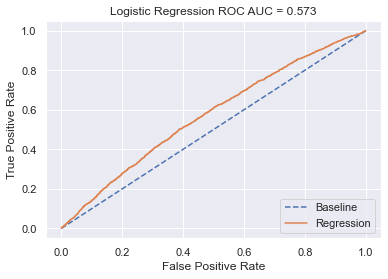

In [956]:
fpr, tpr, threshold = roc_curve(Y_val, probs)
roc_auc = roc_auc_score(Y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [957]:
print(confusion_matrix(Y_val, Y_predicted))

[[12822     0]
 [ 1877     0]]


In [958]:
log_loss(Y_val, Y_predicted)

4.410455357047919

Теперь у нас есть базовая модель, которую мы будем улучшать. Для начала рассмотрим по отдельности все признаки в нашем датасете

## Рассмотрим данные подробнее и обработаем числовые переменные

## Client-id

In [959]:
df.client_id.describe()

count     73799.000000
mean      55137.965094
std       31841.921168
min           1.000000
25%       27440.500000
50%       55274.000000
75%       82758.500000
max      110147.000000
Name: client_id, dtype: float64

73799 уникальных значений. Не более чем порядковый номер заёмщика, от этого признака можно избавиться.

In [960]:
df.drop(['client_id'], inplace = True, axis = 1)

## app_date

In [961]:
df.app_date.value_counts()

18MAR2014    1018
17MAR2014     911
19MAR2014     909
31MAR2014     904
07APR2014     882
             ... 
20APR2014     243
07JAN2014     228
03JAN2014     193
02JAN2014     137
01JAN2014      43
Name: app_date, Length: 120, dtype: int64

Дата подачи заявки на кредит. 120 уникальных значений

In [962]:
#Переведём дату подачи заявки в формат datetime
df['app_date'] = pd.to_datetime(df['app_date'])

In [963]:
#выделим номер месяца в отдельный столбец
df['month'] = df.app_date.apply(lambda s: s.month)

<AxesSubplot:>

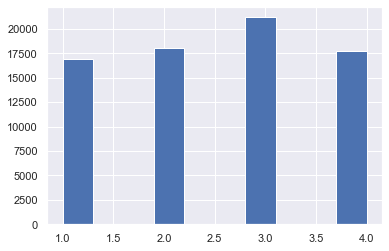

In [964]:
df.month.hist()

In [965]:
#Посмотрим на корреляцию
df.loc[:,'default'].astype('float64').corr(df.loc[:,'month']).astype('float64')

-0.03711507816124177

Теперь колонку month можно добавить к числовым пременным

In [966]:
df['day'] = df.app_date.apply(lambda s: s.day)

<AxesSubplot:>

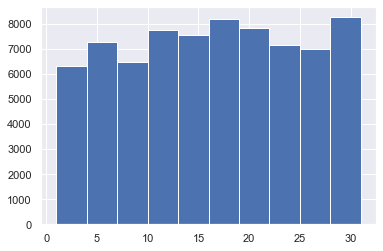

In [967]:
df.day.hist()

In [968]:
#Посмотрим на корреляцию
df.loc[:,'default'].astype('float64').corr(df.loc[:,'day']).astype('float64')

-0.006476950500877778

Корреляция очень низкая, параметр день использовать не будем. Оставим только месяц. Также уберём изначальный параметр app_data

In [969]:
df.drop(['app_date'], inplace = True, axis = 1)

In [970]:
df.drop(['day'], inplace = True, axis = 1)

## education

<AxesSubplot:>

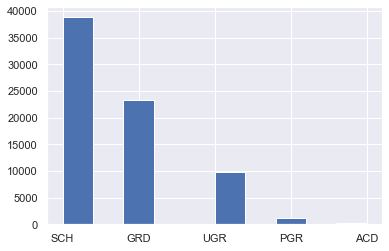

In [971]:
df.education.hist()

уровень образования заёмщика. Категориальный признак, имеющий 5 уникальных значений. В этом столбце присутствуют пропуски.

In [972]:
#Заменим пропуски на наиболее часто встречающееся значение 'SCH'
df.education.fillna('SCH', inplace = True)

In [973]:
#Создаём категориальный признак, чем выше значение - 
#тем выше уровент образования
df['education'] = df['education'].replace(to_replace = education_dict)

## sex

<AxesSubplot:>

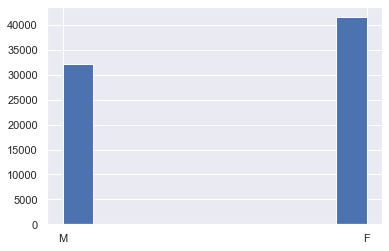

In [974]:
df.sex.hist()

Бинарный признак, обозначающий пол заёмщика. На графике видно, что женщин больше, чем мужчин

default
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: sex, dtype: object

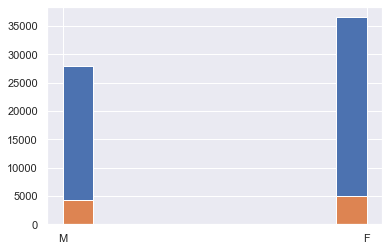

In [975]:
#Также посмотрим на распределение по дефолтным клиентам
df.groupby(by = 'default')['sex'].hist()

## age

count    73799.000000
mean        39.280641
std         11.520378
min         21.000000
25%         30.000000
50%         37.000000
75%         48.000000
max         72.000000
Name: age, dtype: float64

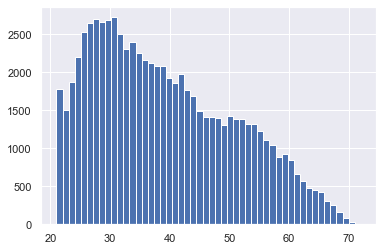

In [976]:
df.age.hist(bins = 50)
df.age.describe()

Проверим наличие выбросов, будум использовать межквартильный размах

In [977]:
get_quantile(df, 'age')

Верхняя граница выбросов: 75.0 Нижняя граница выбросов: 3.0
Количество выбросов: age : 0


Очевидно, что выбросов нет. На графике распределения виден правый хвост. для приведения данных к более нормальному виду логарифмируем признак:

<AxesSubplot:>

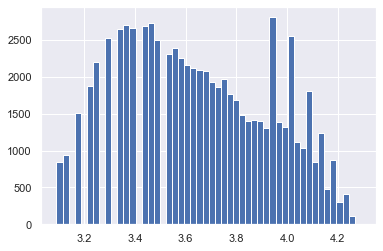

In [978]:
get_log(df, 'age')
df.age.hist(bins = 50)

In [979]:
#Посмотрим на корреляцию
df.loc[:,'default'].astype('float64').corr(df.loc[:,'age']).astype('float64')

-0.02611944876498008

## car

<AxesSubplot:>

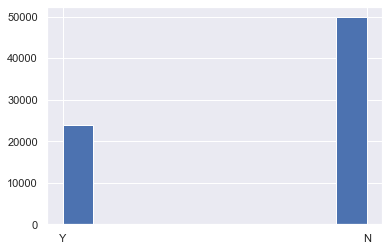

In [980]:
df.car.hist()

Бинарный признак, обозначающий наличие автомобиля у заёмщика. 

default
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: car, dtype: object

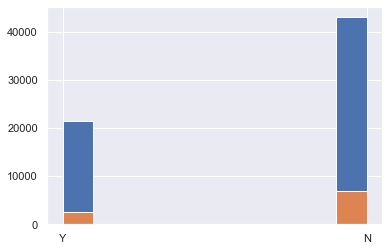

In [981]:
#Заодно посмотрим на распределение по дефолтным клиентам
df.groupby(by = 'default')['car'].hist()

## car_type

<AxesSubplot:>

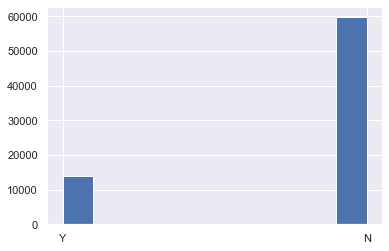

In [982]:
df.car_type.hist()

Бинарный признак, обозначающий наличие автомобиля импортного производства

default
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: car_type, dtype: object

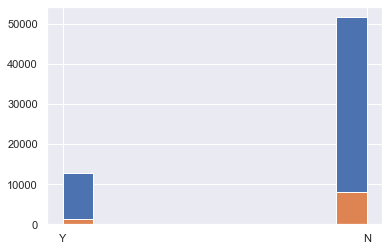

In [983]:
df.groupby(by = 'default')['car_type'].hist()

## decline_app_cnt

count    73799.000000
mean         0.275749
std          0.804272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.000000
Name: decline_app_cnt, dtype: float64

<AxesSubplot:>

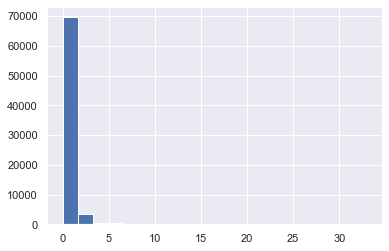

In [984]:
display(df.decline_app_cnt.describe())
df.decline_app_cnt.hist(bins = 20)

Количество отказанных прошлых заявок, основное распределение находится около ноля. Проверим на наличие выбросов

In [985]:
df.groupby(by = 'default')['decline_app_cnt'].mean()

default
0    0.240877
1    0.515472
Name: decline_app_cnt, dtype: float64

В среднем, у людей, не отдавших кредит, количество отклонённых заявок больше

In [986]:
get_quantile(df, 'decline_app_cnt')

Верхняя граница выбросов: 0.0 Нижняя граница выбросов: 0.0
Количество выбросов: decline_app_cnt : 12585


In [987]:
df.decline_app_cnt.value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
24        1
15        1
19        1
22        1
33        1
Name: decline_app_cnt, dtype: int64

Если использовать для ограничения выбросов межквартильный интервал, мы теряем большое количество данных, фактически заменяя всё на 0 и теряя смысл признака.
Упростим признак, заменив все значения больше одного на еденицу. В итоге мы получим бинарный признак 0 - отказанных заявок не было, 1 - отказанные заявки были.

In [988]:
df['decline_app_cnt'] = df['decline_app_cnt'].apply(lambda x: 1 if x>1 else x)

<AxesSubplot:>

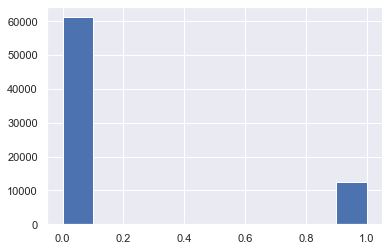

In [989]:
df.decline_app_cnt.hist()

In [990]:
#Посмотрим на корреляцию
df.loc[:,'default'].astype('float64').corr(
    df.loc[:,'decline_app_cnt']).astype('float64')

0.1156482356720367

## good_work

default
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: good_work, dtype: object

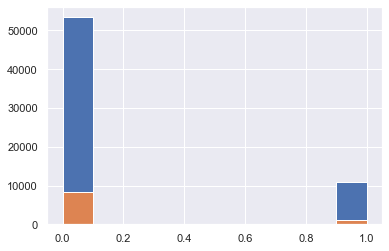

In [991]:
df.groupby(by = 'default')['good_work'].hist()

Хорошая работа зачастую помогает избежать дефолта

## score_bki

count    73799.000000
mean        -1.904724
std          0.498231
min         -3.624586
25%         -2.259534
50%         -1.920823
75%         -1.569831
max          0.199773
Name: score_bki, dtype: float64

<AxesSubplot:>

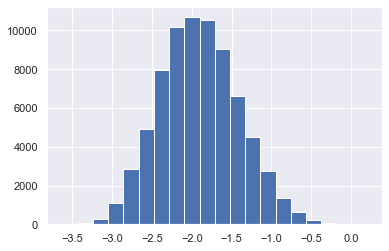

In [992]:
display(df.score_bki.describe())
df.score_bki.hist(bins = 20)

Cкоринговый балл по данным из БКИ. Признак имеет нормальное распределение. Проверим на наличие выбросов.

In [993]:
get_quantile(df, 'score_bki')

Верхняя граница выбросов: -0.5352773974999998 Нижняя граница выбросов: -3.2940876975
Количество выбросов: score_bki : 351


Выбросы заменим на среднее значение

In [994]:
get_filling(df, 'score_bki')

<AxesSubplot:>

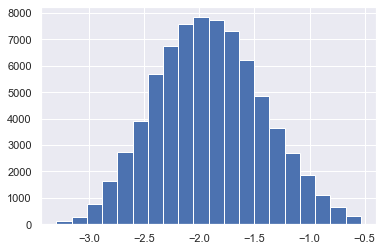

In [995]:
#Посмотрим на получившееся распределение
df['score_bki'].hist(bins = 20)

In [996]:
#и кореляцию
df.loc[:,'default'].astype('float64').corr(
    df.loc[:,'score_bki']).astype('float64')

0.16942944934566673

## bki_request_cnt

count    73799.000000
mean         2.000339
std          2.252073
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         53.000000
Name: bki_request_cnt, dtype: float64

<AxesSubplot:>

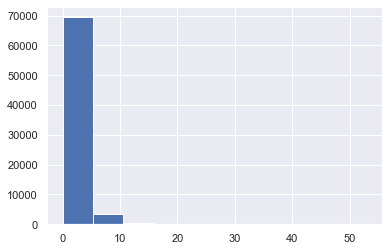

In [997]:
display(df['bki_request_cnt'].describe())
df['bki_request_cnt'].hist()

Числовой пизнак, показывающий количество запросов в БКИ. У распределения заметен правый хвост. Проверим на наличие выбросов:


In [998]:
get_quantile(df, 'bki_request_cnt')

Верхняя граница выбросов: 7.5 Нижняя граница выбросов: -4.5
Количество выбросов: bki_request_cnt : 1755


In [999]:
#Заменим выбросы средним значением
get_filling( df, 'bki_request_cnt')

<AxesSubplot:>

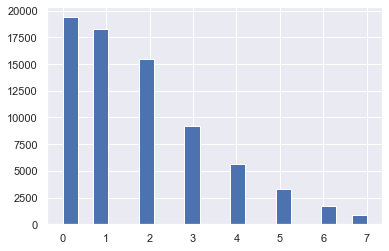

In [1000]:
#Посмотрим что получилось
df['bki_request_cnt'].hist(bins = 20)

## region_rating

50    27523
60    16075
40    12027
80    11469
70     6199
30      300
20      206
Name: region_rating, dtype: int64

<AxesSubplot:>

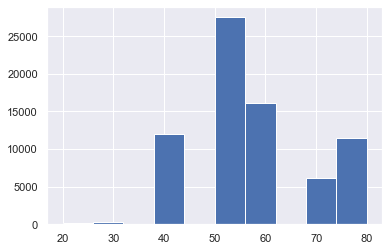

In [1001]:
display(df['region_rating'].value_counts())
df['region_rating'].hist()

default
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: region_rating, dtype: object

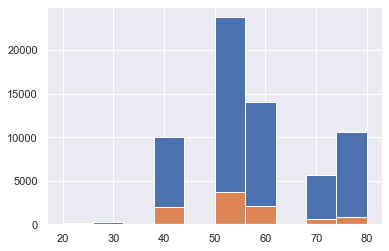

In [1002]:
df.groupby(by = 'default')['region_rating'].hist()

Категориальный признак, имеющий 7 уникальных значений, обозначает рейтинг региона

In [1003]:
#Используем MinMaxScaler
scaler = MinMaxScaler()
rating_minmax = scaler.fit_transform(df.loc[:,['region_rating']])
df['region_rating'] = rating_minmax

0.500000    27523
0.666667    16075
0.333333    12027
1.000000    11469
0.833333     6199
0.166667      300
0.000000      206
Name: region_rating, dtype: int64

<AxesSubplot:>

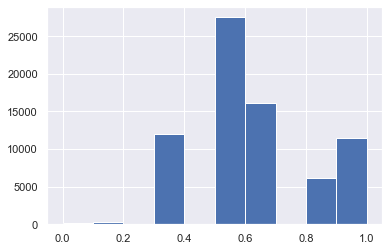

In [1004]:
display(df.region_rating.value_counts())
df.region_rating.hist()

## home_address

<AxesSubplot:>

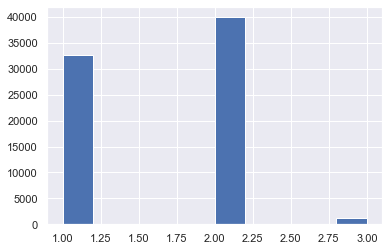

In [1005]:
df['home_address'].hist()

Категориальный признак, имеющий 3 уникальных значения, обозначает признак домашнего адреса

default
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: home_address, dtype: object

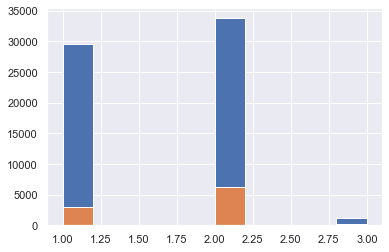

In [1006]:
df.groupby(by = 'default')['home_address'].hist()

## work_address

<AxesSubplot:>

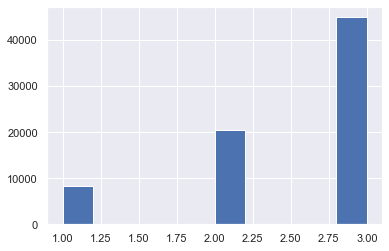

In [1007]:
df['work_address'].hist()

default
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: work_address, dtype: object

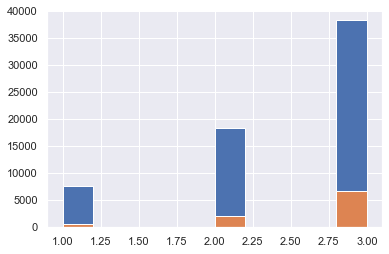

In [1008]:
df.groupby(by = 'default')['work_address'].hist()

Как и home_address это тоже категориальный признак, имеющий 3 значения, обозначает признак рабочего адреса

## income

count      73799.000000
mean       41099.775417
std        46166.322400
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

<AxesSubplot:>

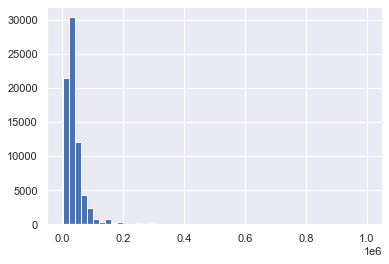

In [1009]:
display(df['income'].describe())
df['income'].hist(bins = 50)

Признак income обозначает доход заёмщика. На графике распределения отчётливо виден правый хвост. Проверим на наличие выбросов:


In [1010]:
get_quantile(df, 'income')

Верхняя граница выбросов: 90000.0 Нижняя граница выбросов: -22000.0
Количество выбросов: income : 4695


In [1011]:
#Заменим выбросы на среднее
get_filling(df, 'income')

<AxesSubplot:>

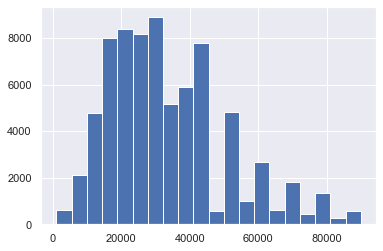

In [1012]:
#Пострим на результат
df['income'].hist(bins = 20)

Нам нужно избавиться от такого большого разброса значений, применим нормализацию

In [1013]:
#Используем MinMaxScaler
scaler = MinMaxScaler()
income_minmax = scaler.fit_transform(df.loc[:,['income']])
df['income'] = income_minmax

<AxesSubplot:>

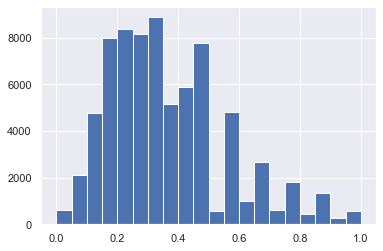

In [1014]:
df['income'].hist(bins = 20)

MinMax нормализация преобразовала доходы заёмщика в пределах от 0 до 1.

## sna

<AxesSubplot:>

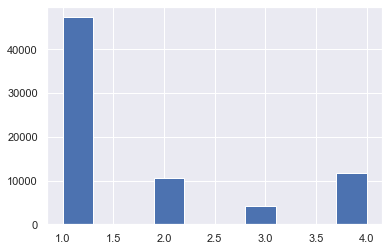

In [1015]:
df.sna.hist()

Категориальный признак, 4 уникальных значения, показывает связь заёмщика с клиентами банка.

In [1016]:
df.sna.value_counts()

1    47301
4    11749
2    10626
3     4123
Name: sna, dtype: int64

## first_time

<AxesSubplot:>

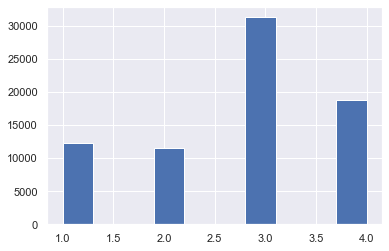

In [1017]:
df.first_time.hist()

Давность наличия информации о заёмщике. Категориальный признак.

## foreign_passport

<AxesSubplot:>

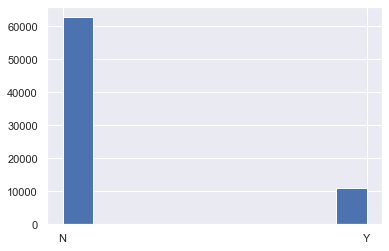

In [1018]:
df.foreign_passport.hist()

In [1019]:
df.groupby(by = 'default')['foreign_passport'].value_counts()

default  foreign_passport
0        N                   54181
         Y                   10246
1        N                    8552
         Y                     820
Name: foreign_passport, dtype: int64

Бинарный признак, указывающий на наличие загранпаспорта у заёмщика. Доля обладателей загранпаспорта среди дефолтных клиентов ниже, чем у недефолтных

## default

Наша ключевая пременная. 0 - означает отсутствие дефолта, 1 - его наличие.

<AxesSubplot:>

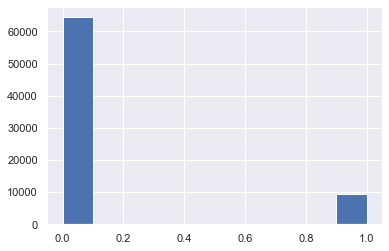

In [1020]:
df.default.hist()

Дефолтных клиентов значительно меньше

## Корреляционный анализ для числовых пременных

<AxesSubplot:>

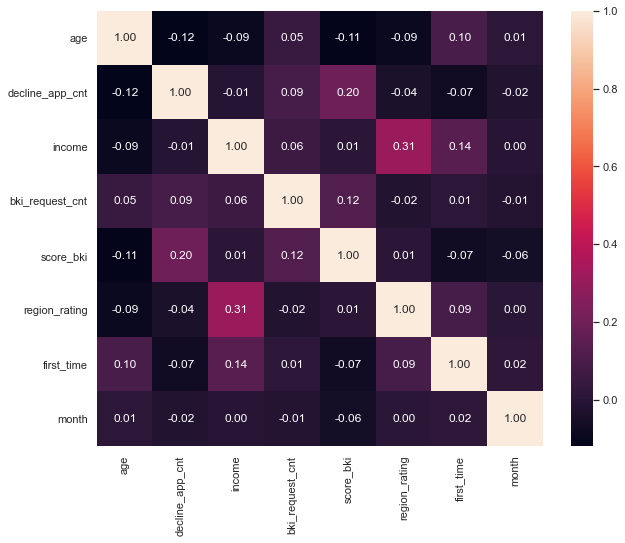

In [1021]:
sns.set(font_scale=1)
plt.subplots(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f')

В целом всё неплохо, однако стоит обратить внимание на кореляцию признаков region_rating и income (0.31), а также score_bki и decline_app_cnt (0.2)

## Значимость категориальных признаков

Для начала мы преобразуем бинарные переменные при помощи LabelEncoder

In [1022]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,month
0,1,1,4.143135,1,1,0,0,-2.008753,1.0,0.500000,1,2,0.191011,4,1,0,0,2
1,1,0,4.094345,0,0,0,0,-1.532276,3.0,0.500000,2,3,0.202247,4,1,0,0,3
2,1,1,3.258097,1,0,1,0,-1.408142,1.0,1.000000,1,2,0.325843,1,4,1,0,2
3,1,0,3.988984,0,0,0,0,-2.057471,2.0,0.500000,2,3,0.101124,1,3,0,0,1
4,2,1,3.891820,0,0,0,1,-1.244723,1.0,0.666667,2,3,0.325843,1,4,1,0,4


Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

<AxesSubplot:>

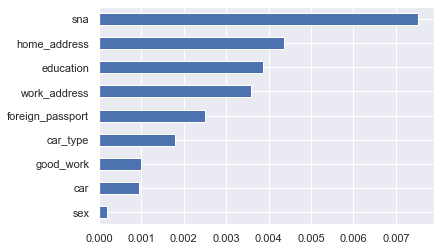

In [1023]:
imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols],
                                     df['default'], discrete_features =True),
                                     index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Наиболее значимый признак из категориальных - sna

In [1024]:
df.head(10)

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,month
0,1,1,4.143135,1,1,0,0,-2.008753,1.0,0.500000,1,2,0.191011,4,1,0,0,2
1,1,0,4.094345,0,0,0,0,-1.532276,3.0,0.500000,2,3,0.202247,4,1,0,0,3
2,1,1,3.258097,1,0,1,0,-1.408142,1.0,1.000000,1,2,0.325843,1,4,1,0,2
3,1,0,3.988984,0,0,0,0,-2.057471,2.0,0.500000,2,3,0.101124,1,3,0,0,1
4,2,1,3.891820,0,0,0,1,-1.244723,1.0,0.666667,2,3,0.325843,1,4,1,0,4
5,1,1,3.332205,1,0,0,1,-2.032257,0.0,0.500000,1,1,0.157303,2,3,0,0,2
6,1,1,3.688879,0,0,0,0,-2.225004,0.0,0.666667,1,2,0.303371,1,1,0,0,2
7,1,0,3.688879,0,0,0,0,-1.522739,1.0,0.500000,2,3,0.494382,3,3,0,0,3
8,1,0,3.931826,1,0,1,0,-1.676061,0.0,0.500000,1,1,0.325843,1,4,0,0,2
9,3,0,4.007333,0,0,0,0,-2.695176,1.0,0.500000,2,3,0.258427,1,3,0,0,1


## Матрица Корреляций

<AxesSubplot:>

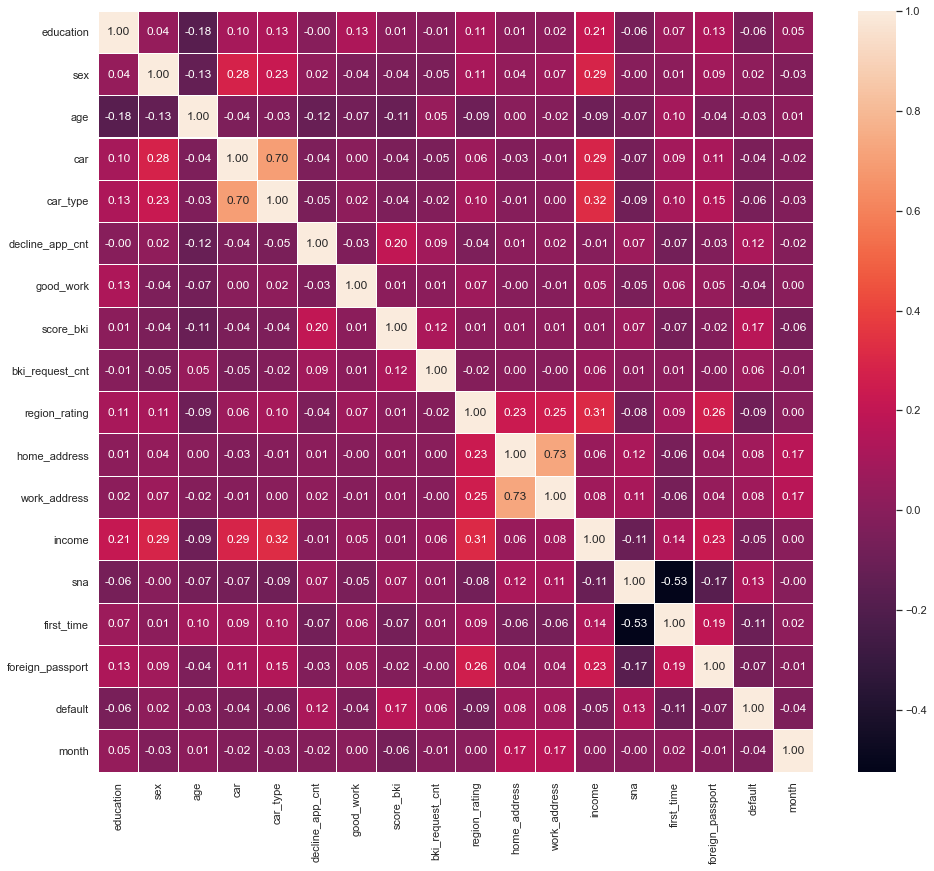

In [1025]:
sns.set(font_scale=1)
plt.subplots(figsize=(16,14))
sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths = 0.1)

Сильная корреляция наблюдается между:
1. рабочим и домашним адресами - 0,73. Удалим рабочий адрес
2. автомобилем и его типом - 0,7. объеденим оба этих признака в новый, т.к. один параметр напрямую следует из другого
3. sna и first_time - -0.53. Удалим first_time, у него ниже корреляция с ключевой переменной

In [1026]:
df['car+car_type'] = df['car']+df['car_type']
#закодируем новую колонку
df['car+car_type'] = label_encoder.fit_transform(df['car+car_type'])

In [1027]:
df.drop(['work_address','car','car_type','first_time'], inplace = True, axis = 1)

<AxesSubplot:>

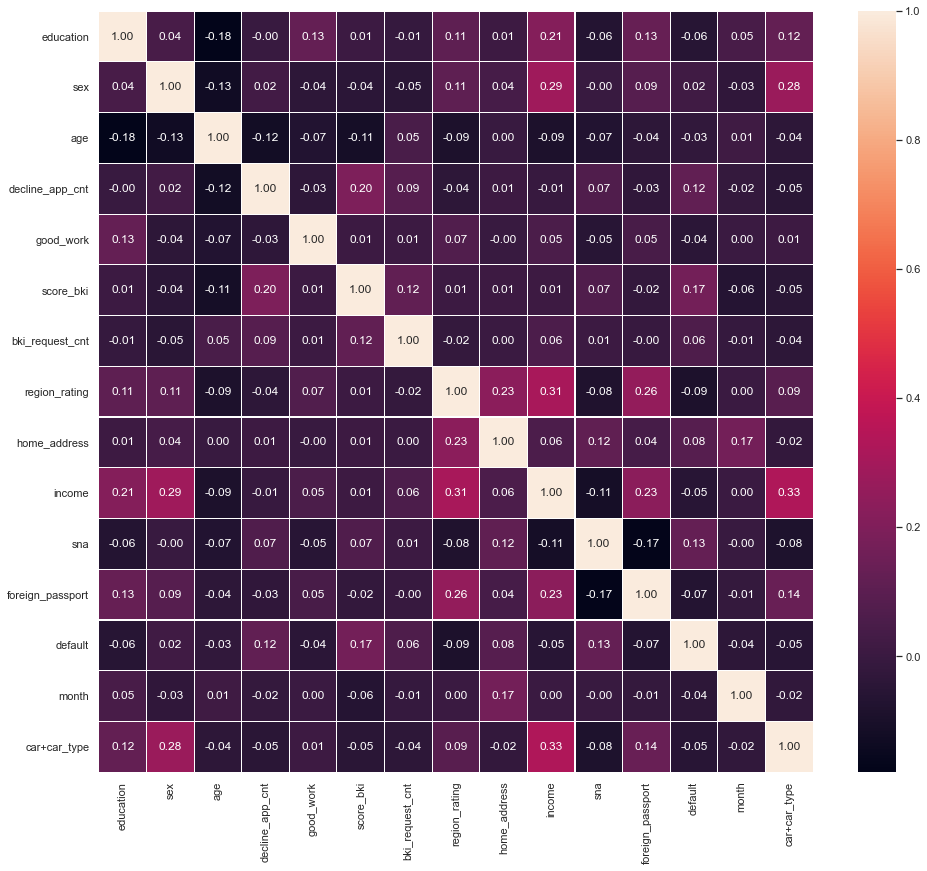

In [1028]:
#Проверим полученный результат
sns.set(font_scale=1)
plt.subplots(figsize=(16,14))
sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths = 0.1)

Найдём статистически важные для модели параметры:

In [1029]:
for column in df.columns:
    get_stat_dif(column)

Найдены статистически значимые различия для колонки education
Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки decline_app_cnt
Найдены статистически значимые различия для колонки good_work
Найдены статистически значимые различия для колонки score_bki
Найдены статистически значимые различия для колонки bki_request_cnt
Найдены статистически значимые различия для колонки region_rating
Найдены статистически значимые различия для колонки home_address
Найдены статистически значимые различия для колонки income
Найдены статистически значимые различия для колонки sna
Найдены статистически значимые различия для колонки foreign_passport
Найдены статистически значимые различия для колонки default
Найдены статистически значимые различия для колонки month
Найдены статистически значимые различия для колонки car+car_type


In [1030]:
#Оставим в иодели только статистически важные параметры
df = df[['education', 'sex', 'car+car_type', 'decline_app_cnt', 'good_work',
        'score_bki', 'bki_request_cnt', 'region_rating', 'home_address',
        'income', 'sna', 'foreign_passport', 'month', 'default']]

In [1038]:
#логарифмируем признаки
for column in ['sna', 'month', 'bki_request_cnt', 'education']:
    df[column] = df[column].apply(lambda s: np.log(s+1))

In [1031]:
score_minmax = scaler.fit_transform(df.loc[:,['score_bki']])
df['score_bki'] = score_minmax

In [1040]:
df['car+car_type'] = df['car+car_type'].apply(lambda s: np.log(s+1))
#Проверим наш датасет
df.head(5)

,education,sex,car+car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,income,sna,foreign_passport,month,default
0,0.693147,1,0.741276,0,0,0.465986,0.693147,0.500000,1,0.191011,1.609438,0,1.098612,0
1,0.693147,0,0.000000,0,0,0.638736,1.386294,0.500000,2,0.202247,1.609438,0,1.386294,0
2,0.693147,1,0.526589,1,0,0.683741,0.693147,1.000000,1,0.325843,0.693147,1,1.098612,0
3,0.693147,0,0.000000,0,0,0.448323,1.098612,0.500000,2,0.101124,0.693147,0,0.693147,0
4,1.098612,1,0.000000,0,1,0.742990,0.693147,0.666667,2,0.325843,0.693147,1,1.609438,0


## Построение модели

In [1041]:
X = df.drop(['default'], axis = 1)
Y = df['default'].values

Разделим данные для обучения следующим образом:

In [1042]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.20, random_state=42)

Обучим модель логистической регрессии

In [1043]:
lrg = LogisticRegression(penalty = 'l2', C=1.0, 
                         class_weight= 'balanced', random_state = 42)
lrg.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced', random_state=42)

## Оценка качества модели

В качестве методов оценки прогностической способности модели будем использовать ROC-анализ, f1-score и confusion matrix

In [1044]:
probs = lrg.predict_proba(X_val)
probs = probs[:,1]

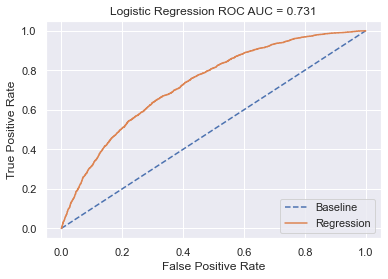

In [1045]:
fpr, tpr, threshold = roc_curve(Y_val, probs)
roc_auc = roc_auc_score(Y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [1046]:
Y_predicted = lrg.predict(X_val)

In [1047]:
сf_mtx = confusion_matrix(Y_val, Y_predicted)
print('Confusion matrix: \n', confusion_matrix(Y_val, Y_predicted))
tn, fp, fn, tp = сf_mtx.ravel()

Confusion matrix: 
 [[8611 4322]
 [ 603 1224]]


In [1048]:
print('Предсказано невозращение кредита клиентом, по факту вернувшим: {} \n\
 или {}% от всех вернувших \n'.format(fp, round((fp/(fp+tn))*100, 2)))
print('Предсказан возврат кредита клиентом, по факту не вернувшим: {} \n\
или {}% от всех не вернувших\n'.format(fn, 
                        round((1-recall_score(Y_val,Y_predicted))*100, 2)))

Предсказано невозращение кредита клиентом, по факту вернувшим: 4322 
 или 33.42% от всех вернувших 

Предсказан возврат кредита клиентом, по факту не вернувшим: 603 
или 33.0% от всех не вернувших



In [1049]:
print('f1-score:', f1_score(Y_val, Y_predicted))
print('recall-score:', recall_score(Y_val, Y_predicted))

f1-score: 0.33202224332022245
recall-score: 0.6699507389162561


## Вывод:

Наивная модель показала следующие метрики:
- ROC - 0.573
- f1-score 0.0

На данном этапе мы получили следующие значения метрик:
- ROC - 0.731 
- f1-score - 0.028

Оставив в датасете только статистически важные признаки мы получили следующие значения метрик:
- ROC - 0.731
- f1-score - 0.0295

Добавив в гиперпараметры class_weight = 'balanced', получили следующие значения метрик:
- ROC - 0.731
- f1-score - 0.3316

При следующих гиперпараметрах: penalty = 'l2', C=1.0, class_weight= 'balanced', random_state = 42, были получены следующие значения метрик:
- ROC - 0.731
- f1-score - 0.3319

Объеденив колонки car и car_type, затем преобразовав при помощи label_encoder, удалось получить следующие значения метрик:
- ROC - 0.734
- f1-score - 0.3355

Таккже стоит отметить, что из-за несбалансированности классов в нашей модели мы  получаем модель, которая считает клиентов "хорошими" . В результате чего кредит одобряется почти всем и мы имеем 1799 не вернувших кредит заёмщиков с предсказанием возврата. Ошибка составила 98.47%. 
Для балансировки модели использовался гиперпараметр class_weight = 'balanced'.
В результате модель начала браковать клиентов, способных вернуть кредит. Но при этом ошибка с невозвращёнными кредитами снизилась до 33,17%

In [1050]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0,4,10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, Y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, Y_train)

#Смотрим на лучшие гиперпараметры
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0
